In [1]:
!pip install --quiet duckdb
# !pip install --quiet jupysql 
# !pip install --quiet duckdb-engine
!pip install --quiet chart-studio
!pip install --quiet pycaret 
!pip install --quiet pandas_profiling
!pip install --quiet dython
!pip install --quiet numpy  --upgrade --user
!pip install --quiet dowhy  --upgrade --user
!pip install --quiet scipy==1.11.3

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 2023.621.222118 requires jupyter-server~=1.16, but you have jupyter-server 2.6.0 which is incompatible.
fitter 1.6.0 requires pandas<3.0.0,>=2.0.3, but you have pandas 1.5.3 which is incompatible.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.23.5 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.10.1 which is incompatible.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0

In [3]:
import warnings
warnings.simplefilter("ignore")

# data engineering
import duckdb
# Import jupysql Jupyter extension to create SQL cells
%load_ext sql

# data processing, compute, auto-EDA
import numpy as np
import scipy
from scipy import stats
from datetime import datetime
import pandas as pd 
from pandas_profiling import ProfileReport

# visualizations for EDA
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# import chart_studio.plotly as py
# import plotly.graph_objs as go
# import cufflinks as cf
# from plotly import figure_factory as FF
# from plotly.offline import iplot
# cf.go_offline() #will make cufflinks offline
# cf.set_config_file(offline=False, world_readable=True)

# correlation scores
from sklearn.metrics import jaccard_score
from dython.nominal import associations
from dython.nominal import identify_nominal_columns

# feature importance
# from pycaret.classification import *
from pycaret.regression import *

# causality inference
from dowhy import CausalModel

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


# Objective: 
### Predict estimated delivery time in seconds.
(from created_at to actual_delivery_time)

# The Data

#### Data description #### 
The attached file `historical_data.csv` contains a subset of deliveries received at DoorDash in early 2015 in a subset of the cities. Each row in this file corresponds to one unique delivery. Each column corresponds to a feature as explained below. Note all money (dollar) values given in the data are in cents and all time duration values given are in seconds. 
The target value to predict here is the total seconds value between `created_at` and `actual_delivery_time`. 

We have added noise to the dataset to obfuscate certain business details. Both `historical_data.csv` and `data_to_predict.json` include similar noise. We will only be evaluating your model's performance on this noisy, artificial dataset. The baseline model we will compare it was also trained and evaluated on the same noisy dataset.

#### Columns in historical_data.csv

### Time features
* market_id: A city/region in which DoorDash operates, e.g., Los Angeles, given in the data as an id
* created_at: Timestamp in UTC when the order was submitted by the consumer to DoorDash. (Note this timestamp is in UTC, but in case you need it, the actual timezone of the region was US/Pacific)
* actual_delivery_time: Timestamp in UTC when the order was delivered to the consumer

### Store features 
* store_id: an id representing the restaurant the order was submitted for
* store_primary_category: cuisine category of the restaurant, e.g., italian, asian
* order_protocol: a store can receive orders from DoorDash through many modes. This field represents an id denoting the protocol

### Order features
* total_items: total number of items in the order
* subtotal: total value of the order submitted (in cents)
* num_distinct_items: number of distinct items included in the order
* min_item_price: price of the item with the least cost in the order (in cents)
* max_item_price: price of the item with the highest cost in the order (in cents)

### Market features
DoorDash being a marketplace, we have information on the state of marketplace when the order is placed, that can be used to estimate delivery time. The following features are values at the time of * *`created_at` (order submission time)
* total_onshift_dashers: Number of available dashers who are within 10 miles of the store at the time of order creation 
* total_busy_dashers: Subset of above `total_onshift_dashers` who are currently working on an order
* total_outstanding_orders: Number of orders within 10 miles of this order that are currently being processed.

### Predictions from other models:
We have predictions from other models for various stages of delivery process that we can use.
* estimated_order_place_duration: Estimated time for the restaurant to receive the order from DoorDash (in seconds)
* estimated_store_to_consumer_driving_duration: Estimated travel time between store and consumer (in seconds)



#####################################################################################
#### Data to predict #### 
Also attached here is `data_to_predict.json`, which provides the new data that you must predict on using the model you build. This data was generated similar to the `historical_data.csv` and it contains the same columns as above, except for the following differences:
  * This file does not contain `actual_delivery_time`, since that is unknown at the time of prediction
  * This file contains `delivery_id` as additional field
  * This file may contain other additional fields
Each row of the data is one data point to predict on. Note that `data_to_predict.json` contains orders from later weeks compared to `historical_data` 

In [4]:
data = pd.read_csv('/kaggle/input/doordash-takehome/historical_data.csv')
data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [5]:
# How many distinct deliveries
len(data)

In [6]:
# Data Time Frame
query = """
select min(created_at)
, max(created_at)
, cast(max(created_at) as timestamp) - cast(min(created_at) as timestamp)
from data
"""

duckdb.query(query).df()

,min(created_at),max(created_at),(CAST(max(created_at) AS TIMESTAMP) - CAST(min(created_at) AS TIMESTAMP))
0,2014-10-19 05:24:15,2015-02-18 06:00:44,122 days 00:36:29


~ 4 months of delivery activity

# Exploratory Data Analysis

# Need to categorize columns into data types:

* categorical 
    * binary (0/1)
    * multiple types (movie genres)
        * market_id
        * store_id
        * store_primary_category
        * order_protocol
    * ordinal
        * created_at
        * actual_delivery_time
    * no survey numbers (rank)
* numerical 
    * (non-discrete)/continuous 
        * subtotal
        * min_item_price
        * max_item_price
    * (discrete) 
        * total_items
        * num_distinct_items
        * total_onshift_dashers
        * total_busy_dashers
        * total_outstanding_orders
        * estimated_order_place_duration
        * estimated_store_to_consumer_driving_duration 

* no time series

Based on data type, determines types of graphs used to explore data.

## Univariate analysis 
- mostly to see if there are outliers
### Categorical

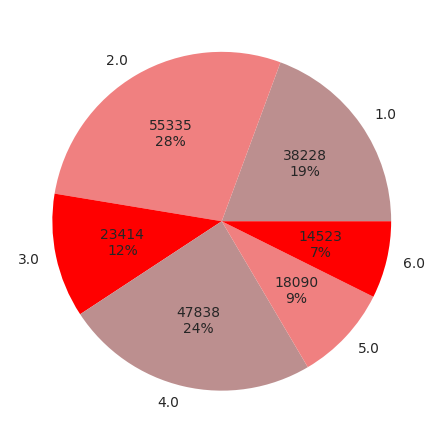

In [7]:
# Different markets' proportion in sample data

def label_function(val):
    return f'{val / 100 * len(data):.0f}\n{val:.0f}%'

data.groupby('market_id').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 10},
                                  colors=['rosybrown', 'lightcoral', 'red'])
plt.show()

Markets 2, 4 and 1 have the highest proportion of deliveries.

In [8]:
query = """
select store_id as restaurant
, count(*) as counts
from data
group by 1
order by 2 desc
"""

duckdb.query(query).df()

,restaurant,counts
0,6865,937
1,1311,863
2,314,815
3,1686,765
4,3937,721
...,...,...
6738,106,1
6739,5511,1
6740,578,1
6741,6290,1


In [9]:
query = """
select count(distinct store_id) as unique_restaurants
from data
"""

duckdb.query(query).df() 

,unique_restaurants
0,6743


In [10]:
query = """
select 
count(distinct store_primary_category) as unique_restaurant_categories
from data
"""

duckdb.query(query).df() 

,unique_restaurant_categories
0,74


<Axes: xlabel='store_primary_category'>

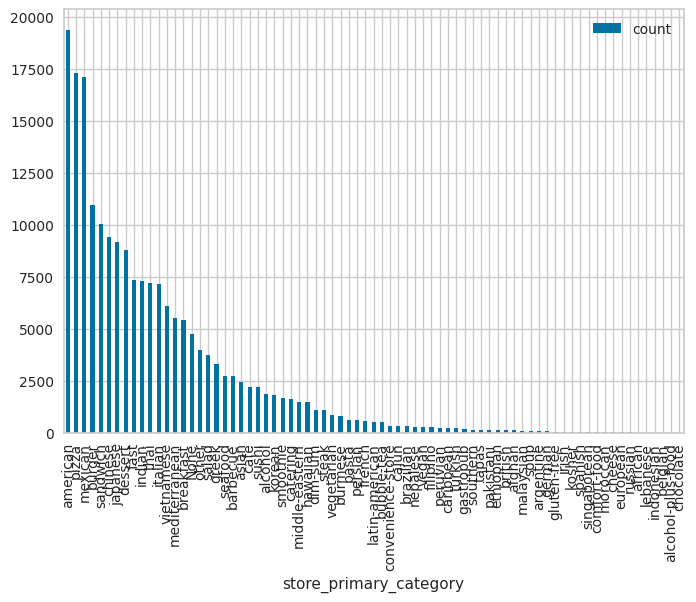

In [11]:
query = """
select store_primary_category
, count(*) as count
from data
group by 1
order by 2 desc
"""

sc = duckdb.query(query).df()

sc.plot.bar(x='store_primary_category', y='count', rot=90)

In [12]:
query = """
select store_primary_category 
, count(*) as count
from data
group by 1
order by 2 desc
"""

duckdb.query(query).df()[:20] #Mostly American

,store_primary_category,count
0,american,19399
1,pizza,17321
2,mexican,17099
3,burger,10958
4,sandwich,10060
5,chinese,9421
6,japanese,9196
7,dessert,8773
8,fast,7372
9,indian,7314


American, pizza and Mexican are the most favorite ordered cuisines/food items.

In [13]:
query = """
select order_protocol
, count(*) as count
from data
group by 1
order by 2 desc
"""

opc = duckdb.query(query).df()
opc

,order_protocol,count
0,1.0,54725
1,3.0,53199
2,5.0,44290
3,2.0,24052
4,4.0,19354
5,NaN,995
6,6.0,794
7,7.0,19


<Axes: xlabel='order_protocol'>

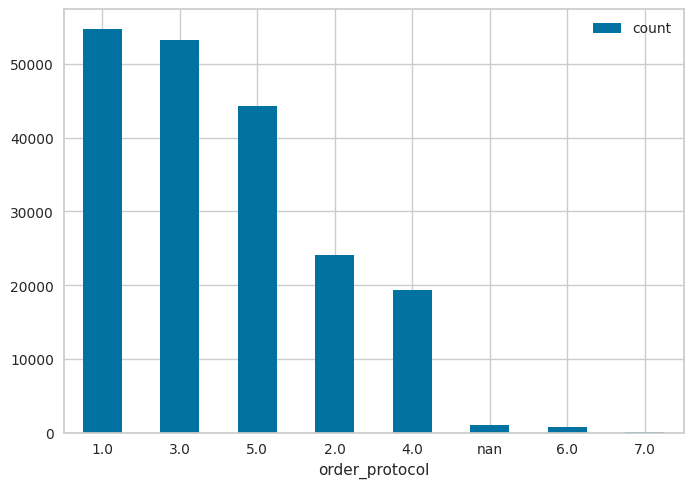

In [14]:
opc.plot.bar(x='order_protocol', y='count', rot=0)

### Numerical

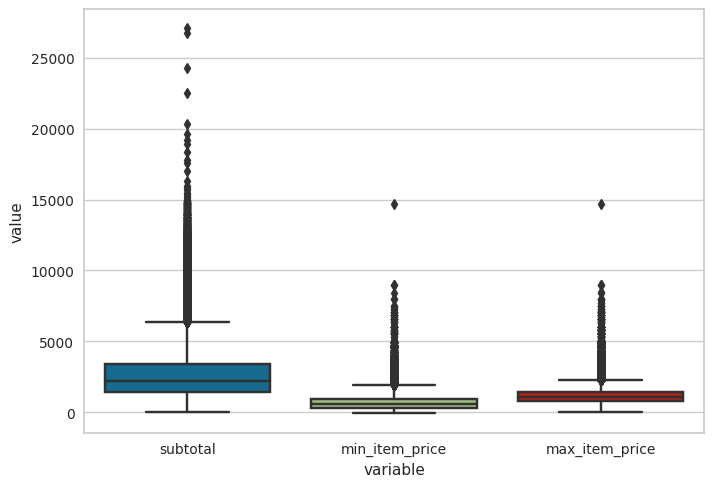

In [15]:
sns.boxplot(x="variable", y="value", data=pd.melt(data[['subtotal', 'min_item_price', 'max_item_price']]))
plt.show()

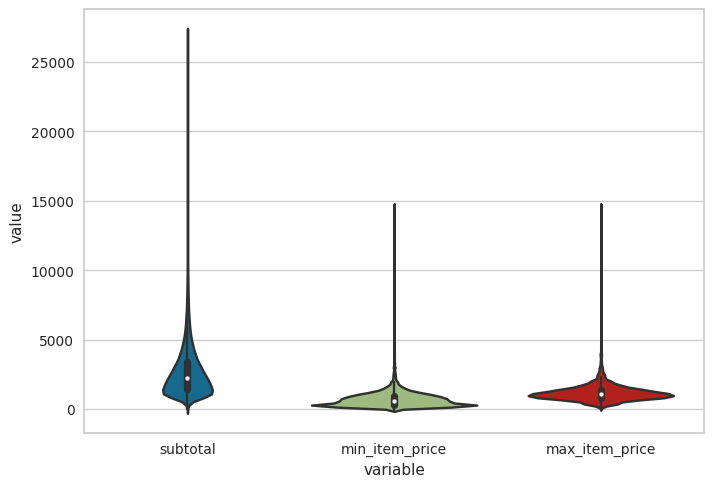

In [16]:
sns.violinplot(x="variable", y="value", data=pd.melt(data[['subtotal', 'min_item_price', 'max_item_price']]))
plt.show()

Most outliers in subtotal

In [17]:
# Many outliers again
subtotal_dol = data['subtotal']/100
subtotal_dol.describe() # Most orders are $33 and under; %271 is catered

count    197428.000000
mean         26.823314
std          18.230937
min           0.000000
25%          14.000000
50%          22.000000
75%          33.950000
max         271.000000
Name: subtotal, dtype: float64

<Axes: xlabel='variable', ylabel='value'>

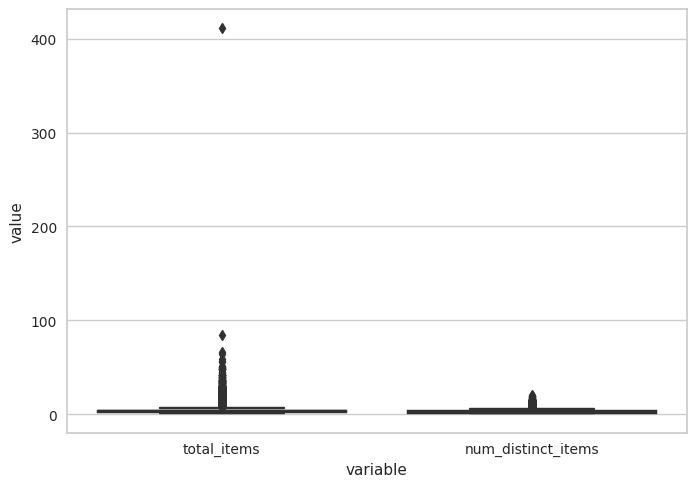

In [18]:
sns.boxplot(x="variable", y="value", data=pd.melt(data[['total_items', 'num_distinct_items']]))

Outlier in total_items. Let's see in detail with quartile distribution.

In [19]:
data.total_items.describe()

count    197428.000000
mean          3.196391
std           2.666546
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max         411.000000
Name: total_items, dtype: float64

In [20]:
# Let's take out and see what distribution is without it
query = """
select *
from data
where total_items != 411
"""

data2 = duckdb.query(query).df()

<Axes: xlabel='variable', ylabel='value'>

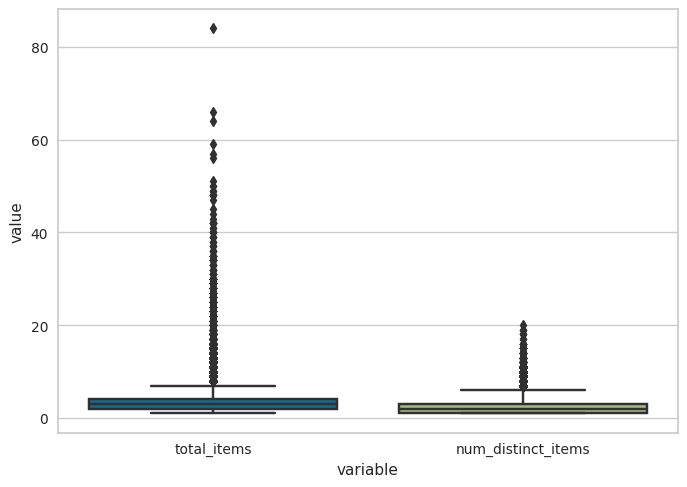

In [21]:
sns.boxplot(x="variable", y="value", data=pd.melt(data2[['total_items', 'num_distinct_items']]))

<Axes: xlabel='variable', ylabel='value'>

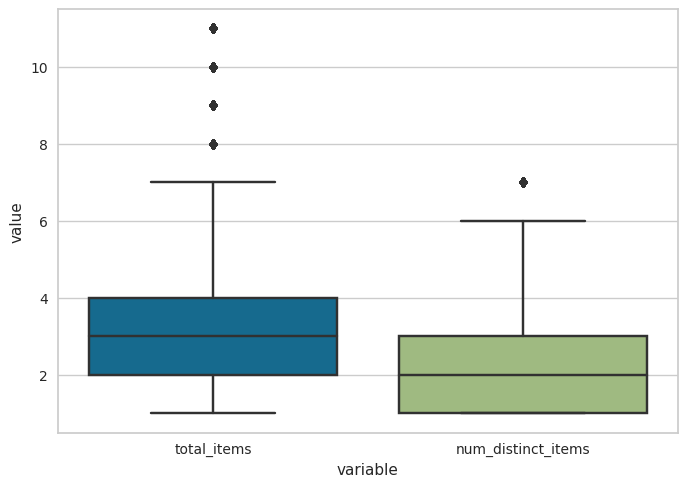

In [22]:
#Let's see what the meat of the data is by using z-score to eliminate any data outside of 3 standard deviations from mean
data3 = data[(np.abs(stats.zscore(data[['total_items', 'num_distinct_items']])) < 3).all(axis=1)]
sns.boxplot(x="variable", y="value", data=pd.melt(data3[['total_items', 'num_distinct_items']]))

Much cleaner. We see that majority of total items per delivery is 3 with 2 unique items.

<Axes: xlabel='variable', ylabel='value'>

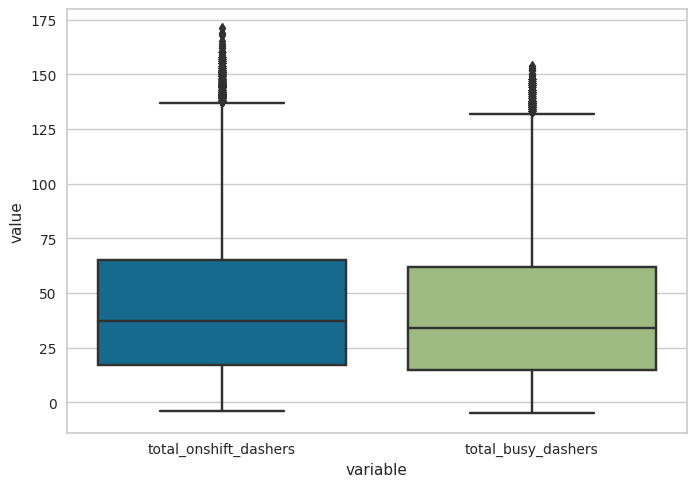

In [23]:
sns.boxplot(x="variable", y="value", data=pd.melt(data[['total_onshift_dashers', 'total_busy_dashers']]))

Looks like there is a good amount of overlap, with more variability with total onshift dashers. Some may be just loggin in on the app.

<Axes: xlabel='dash_coverage'>

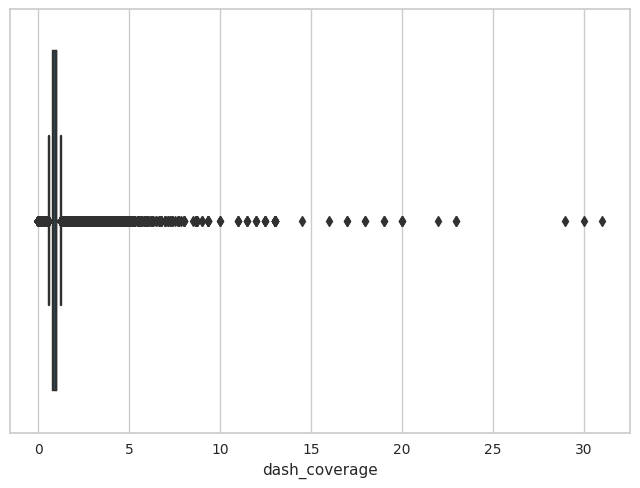

In [24]:
#Best to do a ratio to get coverage/check in on idleness

query = """
select *
, total_busy_dashers/total_onshift_dashers as dash_coverage
from data
where total_onshift_dashers >=0
and total_busy_dashers >= 0
"""

data4 = duckdb.query(query).df()
sns.boxplot(x=data4["dash_coverage"])

In [25]:
data4["dash_coverage"].describe()

count    177513.000000
mean          0.950438
std           0.401563
min           0.000000
25%           0.826923
50%           0.962264
75%           1.000000
max          31.000000
Name: dash_coverage, dtype: float64

75% of the data has 100% coverage. Need to check DoorDash's internal metrics to see what is their baseline success for this metric.

<Axes: xlabel='total_outstanding_orders'>

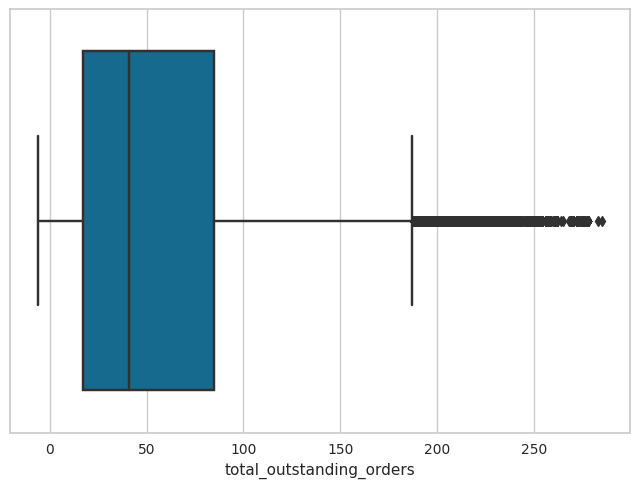

In [26]:
sns.boxplot(x=data["total_outstanding_orders"])

<Axes: xlabel='variable', ylabel='value'>

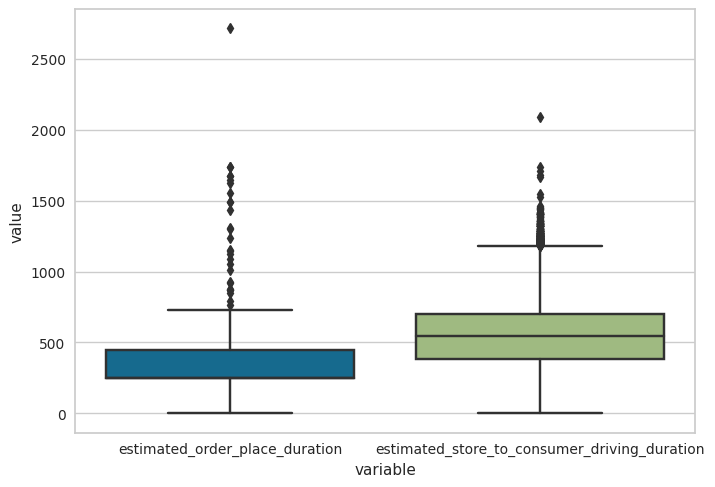

In [27]:
sns.boxplot(x="variable", y="value", data=pd.melt(data[['estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration']]))

In [28]:
data['estimated_order_place_duration'].describe()

count    197428.000000
mean        308.560179
std          90.139653
min           0.000000
25%         251.000000
50%         251.000000
75%         446.000000
max        2715.000000
Name: estimated_order_place_duration, dtype: float64

In [29]:
# Last but not least, target value: delivery prediction time (actual_delivery_time - created_at)
query = """
select *
, date_diff('minute', cast(created_at as timestamp), cast(actual_delivery_time as timestamp)) as delivery_time
from data
"""

data5 = duckdb.query(query).df()
data5.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_time
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,63.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,67.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,None,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,30.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,None,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,52.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,None,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,40.0


<Axes: xlabel='delivery_time'>

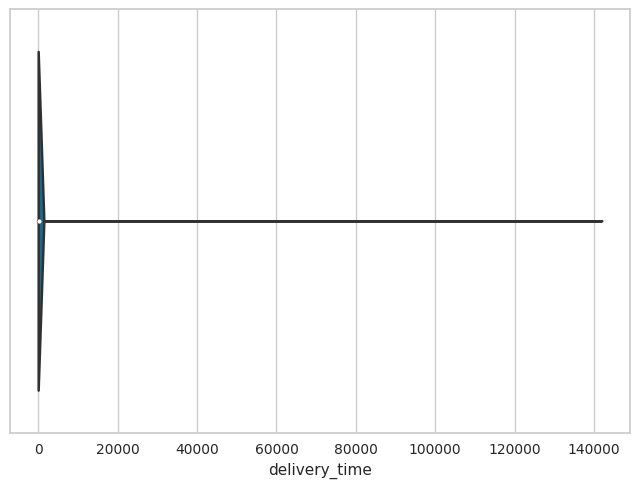

In [30]:
sns.violinplot(x=data5["delivery_time"])

In [31]:
data5.delivery_time.describe()

count    197421.000000
mean         48.473420
std         320.492084
min           2.000000
25%          35.000000
50%          44.000000
75%          56.000000
max      141947.000000
Name: delivery_time, dtype: float64

In [32]:
# Most deliveries take 45 minutes to an hour.
141947/60/24 # max has to be an advance preorder (catering) / app input/API error. Will need to definitely get rid of outliers before model building...

In [33]:
len(data) #before outliers taken out

In [34]:
# Adding in target value: delivery time
query = """
select *
, date_diff('second', cast(created_at as timestamp), cast(actual_delivery_time as timestamp)) as delivery_time
from data
"""

data = duckdb.query(query).df()
data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_time
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,None,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,None,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,None,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0


<Axes: xlabel='delivery_time'>

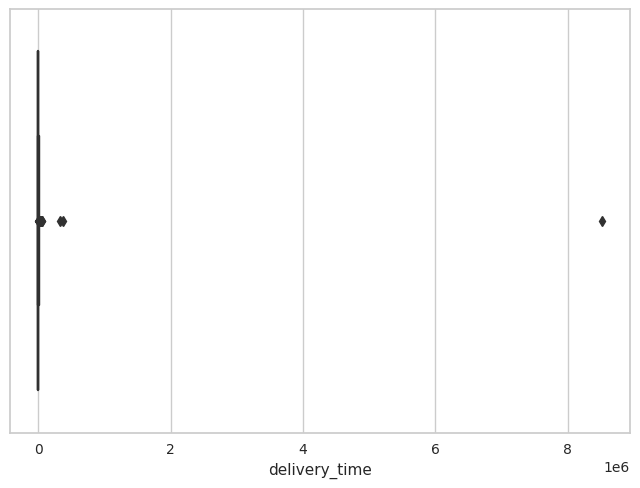

In [35]:
sns.boxplot(x=data["delivery_time"])

In [36]:
# Getting rid of some outliers so that plotting is clearer

query = """
select *
from data
where total_items < 411
and estimated_order_place_duration < 2715
and delivery_time < 300000
"""

data = duckdb.query(query).df()
len(data) #after outliers taken out

In [37]:
# breaking up order creation into different data components
def extract_date_features(data):
    data['created_at'] = pd.to_datetime(data['created_at']) 
    
    data['hour'] = data['created_at'].dt.hour
    data["day"] = data['created_at'].dt.day
    data['day_of_week'] = data['created_at'].dt.day_of_week.astype(int)
    data['is_weekend'] = np.where(data['day_of_week'].isin([5, 6]), 1, 0)
    data["month"] = data['created_at'].dt.month
    data["quarter"] = data['created_at'].dt.quarter
    data["is_month_start"] = data['created_at'].dt.is_month_start.astype(int)
    data["is_month_end"] = data['created_at'].dt.is_month_end.astype(int)
    data["is_quarter_start"] = data['created_at'].dt.is_quarter_start.astype(int)
    data["is_quarter_end"] = data['created_at'].dt.is_quarter_end.astype(int)
#     data["year"] = data['created_at'].dt.year
#     data["is_year_start"] = data['created_at'].dt.is_year_start.astype(int)
#     data["is_year_end"] = data['created_at'].dt.is_year_end.astype(int)
extract_date_features(data)
data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,hour,day,day_of_week,is_weekend,month,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,...,22,6,4,0,2,1,0,0,0,0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,...,21,10,1,0,2,1,0,0,0,0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,None,1.0,1,1900,1,1900,...,20,22,3,0,1,1,0,0,0,0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,None,1.0,6,6900,5,600,...,21,3,1,0,2,1,0,0,0,0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,None,1.0,3,3900,3,1100,...,2,15,6,1,2,1,0,0,0,0


In [38]:
nom_nom_df = data[['total_items',
 'subtotal',
 'num_distinct_items',
 'min_item_price',
 'max_item_price',
 'total_onshift_dashers',
 'total_busy_dashers',
 'total_outstanding_orders',
 'estimated_order_place_duration',
 'estimated_store_to_consumer_driving_duration',
 'hour',
 'day',
 'day_of_week',
 'is_weekend',
 'month',
 'quarter',
 'is_month_start',
 'is_month_end',
 'is_quarter_start',
 'is_quarter_end',
 'delivery_time']]

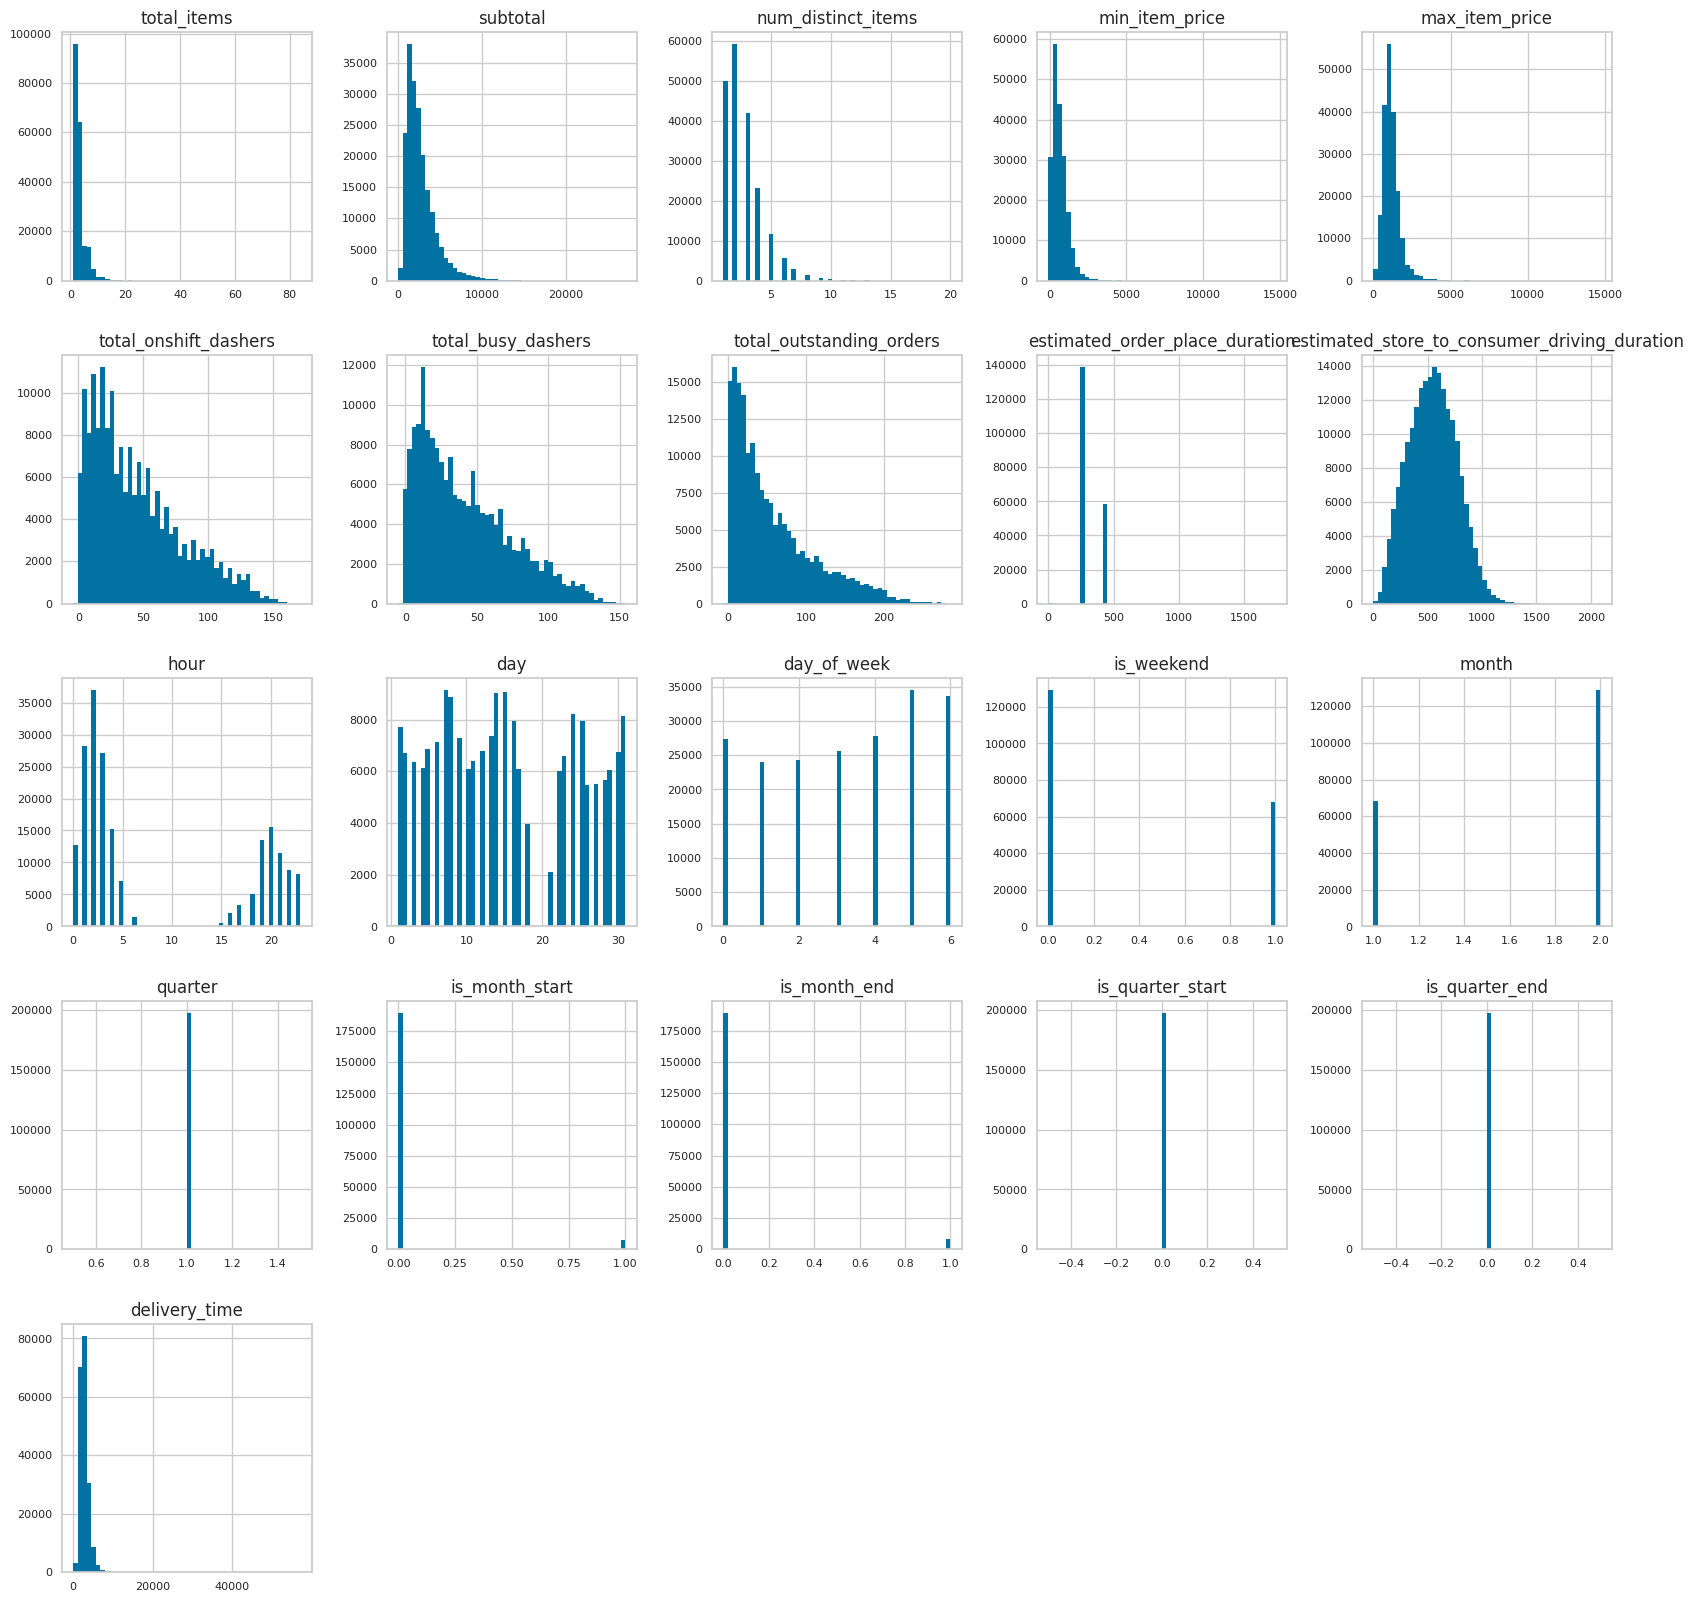

In [39]:
# Condensed
nom_nom_df.hist(figsize=(20, 20), bins=50, xlabelsize=8, ylabelsize=8); # ; avoid having the matplotlib verbose informations

___________

## Bivariate Analysis

# Comparing Different Variables (Univariate, then bivariate and finally multivariate)

Comparison is done to see if variables:
1. covary (as x gets smaller/larger, then y gets smaller/larger)
2. depend on one another (x cannot happen without y)
3. predict one another (x leads to y)

Possibilities between variables:

** determined by A/B Test. For cause in question, expose to experimental group from random sample of population. If same measurement between ctl and test group shows higher reading with stat sig in exp group, then there is effect (skip) from cause (e.g. price changes)

* A causes B (direct causation);
* B causes A (reverse causation);
* A and B are both caused by C (common causation);
* There is no connection between A and B; the correlation is a coincidence.

Correlations are standardised to vary between -1 and +1, with 0 representing no relationship, -1 a perfect negative relationship, and +1 a perfect positive relationship.

1. Uni-variate (delivery time)
    ** make sure to plot histograms to check for normal distribution before performing correlation plots
    - Categorical data
    -- bar (get counts of each category)
    -- pie (get normalized counts- count divided by whole pop)
    -- line (counts of categories over time)

    - Continuous data
    -- histogram (group continuous data and get count of groups)
    -- line (delivery time over time) 
    -- violin (density of quantile distribution (3-D/kde version of boxplot)
    
2. Bi-variate (x vs delivery time)

    - Nominal by nominal: Contingency table, Pearson's chi-square test, Phi/Cramer's V
    - Ordinal by ordinal: Spearman's rho, Kendall's tau-b
    - Dichotomous by interval/ratio: Point biserial correlation coefficient
    - Interval/ration by interval/ratio: Pearson product-moment correlation coefficient
    
    Correlational analyses should be accompanied by appropriate bivariate graphs, such as:

    - Nominal by nominal: Clustered bar charts
    - Ordinal by ordinal: Scatterplot (with point bins)
    - Interval/ratio by interval/ratio: Scatterplot

3. Multi-variate (x, z vs delivery time)

Remember that correlation does not prove causation. Relationship between two variables may be caused by third variable. And this is why multi-variate analysis is important.

    - Pivot tables
    - Heatmaps
    - 3D Visualizations

## Approaching Correlation (not Causation) with Meaning and Relevance of Each Variable
### Segments and Expectation on Delivery Time
* Time 
    * created_at - High
    * actual_delivery_time - High
    
* Food
   * market_id - High
   * store_id - Medium
   * store_primary_category - Medium
   * subtotal - High
   * min_total_price _ Medium
   * max_total_price - Medium

* Logistics
    * order_protocol - Medium
    * total_items _ Medium
    * num_distinct_items - Medium
    * total_onshift_dashers - Medium
    * total_busy_dashers - Medium
    * total_outstanding_orders - High
    * estimated_order_place_duration - High
    * estimated_store_to_consumer_driving_duration - High
    

# Feature Engineering 
Adding some more predictors for delivery time before examining correlation

In [40]:
nom_nom_df.corr()['delivery_time'][:-1]

total_items                                     0.118333
subtotal                                        0.204299
num_distinct_items                              0.147840
min_item_price                                  0.014748
max_item_price                                  0.126095
total_onshift_dashers                           0.067558
total_busy_dashers                              0.086863
total_outstanding_orders                        0.173705
estimated_order_place_duration                  0.097296
estimated_store_to_consumer_driving_duration    0.223314
hour                                           -0.157915
day                                            -0.064167
day_of_week                                     0.000035
is_weekend                                      0.060264
month                                           0.061939
quarter                                              NaN
is_month_start                                  0.013855
is_month_end                   

In [41]:
data_num_corr = nom_nom_df.corr()['delivery_time'][:-1] # -1 because the latest row is delivery_time
golden_features_list = data_num_corr[abs(data_num_corr) > 0.5].sort_values(ascending=False)
print("There is {} strongly correlated values with Delivery Time:\n{}".format(len(golden_features_list), golden_features_list))

There is 0 strongly correlated values with Delivery Time:
Series([], Name: delivery_time, dtype: float64)


not much found here...

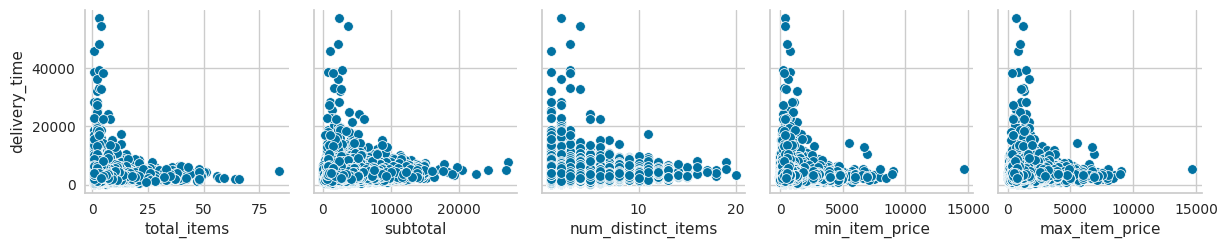

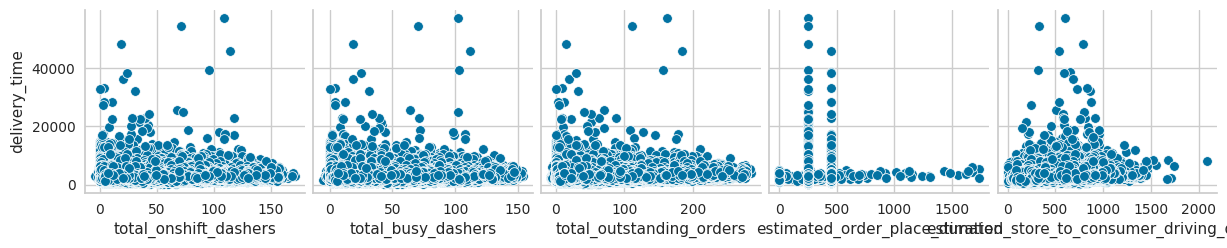

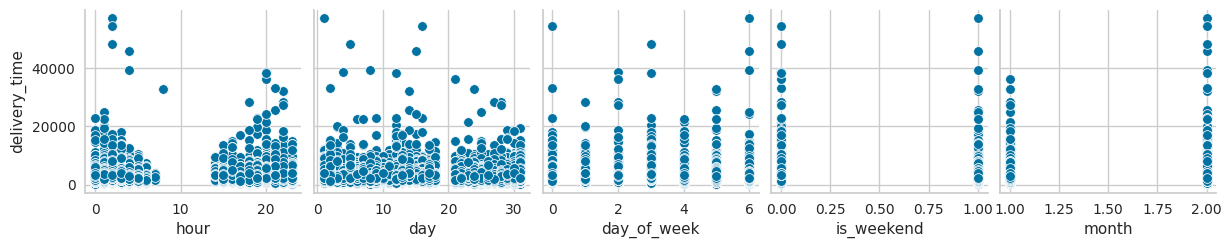

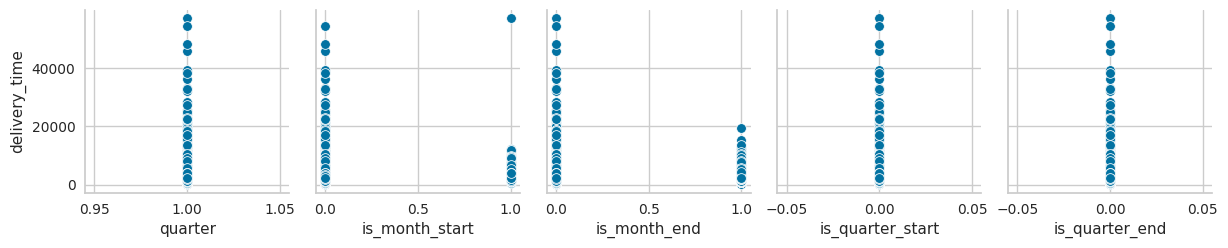

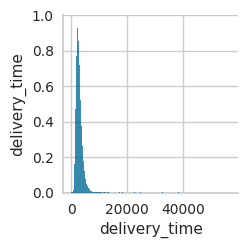

In [42]:
for i in range(0, len(nom_nom_df.columns), 5):
    sns.pairplot(data=nom_nom_df,
                x_vars=nom_nom_df.columns[i:i+5],
                y_vars=['delivery_time'])

# There is a definitely different viewpoint when only a sample of the data is taken

The amount of time it took to go from store to consumer had the highest correlation 0.22331421638358206 compared to subtotal 0.2042993477556852 and total outstanding orders 0.17370487214167515 .


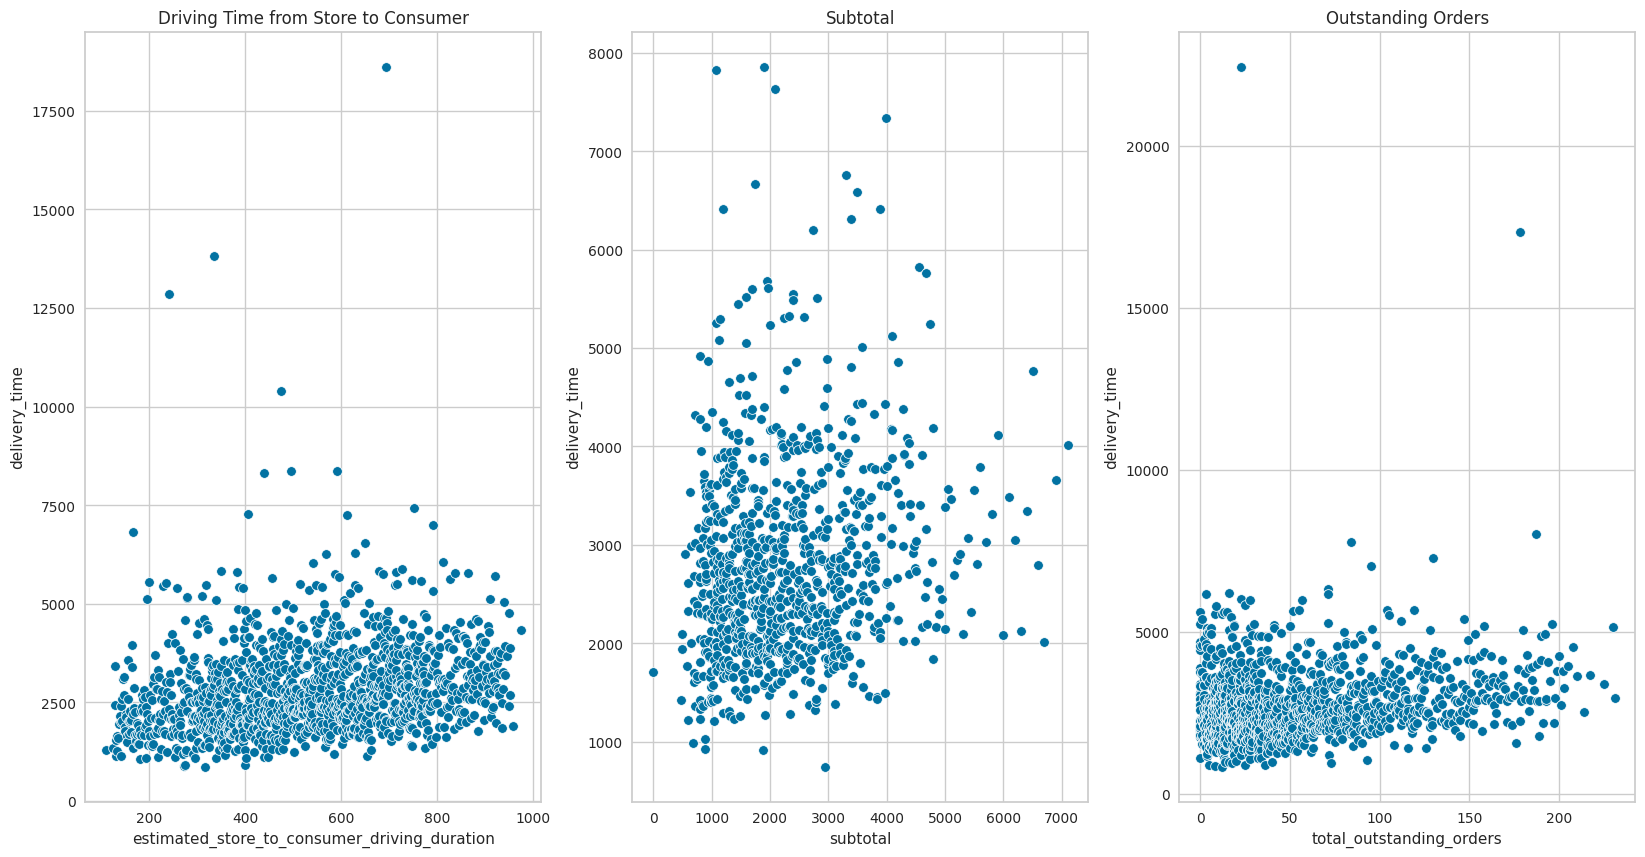

In [43]:
fig, axes = plt.subplots(1, 3,figsize=(20,10))

store_to_consumer_driving_time =data.groupby('estimated_store_to_consumer_driving_duration', group_keys=False).apply(lambda x: x.sample(frac=0.007))
sns.scatterplot(ax=axes[0],data=store_to_consumer_driving_time, x="estimated_store_to_consumer_driving_duration", y="delivery_time")
axes[0].set_title('Driving Time from Store to Consumer')

subtotal=data.groupby('subtotal', group_keys=False).apply(lambda x: x.sample(frac=0.007))
sns.scatterplot(ax=axes[1],data=subtotal, x="subtotal", y="delivery_time")
axes[1].set_title('Subtotal')

outstanding_orders=data.groupby('total_outstanding_orders', group_keys=False).apply(lambda x: x.sample(frac=0.007))
sns.scatterplot(ax=axes[2],data=outstanding_orders, x="total_outstanding_orders", y="delivery_time")
axes[2].set_title('Outstanding Orders')

print('The amount of time it took to go from store to consumer had the highest correlation {} compared to subtotal {} and total outstanding orders {} .'.format(data.estimated_store_to_consumer_driving_duration.corr(data['delivery_time']),data.subtotal.corr(data['delivery_time']), data.total_outstanding_orders.corr(data['delivery_time'])))

In [44]:
# Let's see if this may get some better correlations
import operator

individual_features_df = []
for i in range(0, len(nom_nom_df.columns) - 1): # -1 because the last column is SalePrice
    tmpDf = nom_nom_df[[nom_nom_df.columns[i], 'delivery_time']]
    tmpDf = tmpDf[tmpDf[nom_nom_df.columns[i]] != 0]
    individual_features_df.append(tmpDf)

all_correlations = {feature.columns[0]: feature.corr()['delivery_time'][0] for feature in individual_features_df}
all_correlations = sorted(all_correlations.items(), key=operator.itemgetter(1))
for (key, value) in all_correlations:
    print("{:>15}: {:>15}".format(key, value))

           hour: -0.18100187944926263
            day: -0.06416701824524042
 min_item_price: 0.014152062739716323
          month: 0.061939475750950615
    day_of_week: 0.07221378805399731
total_onshift_dashers: 0.0818076584004844
estimated_order_place_duration: 0.09725808806605013
total_busy_dashers: 0.10071431662331591
    total_items: 0.1183333197055365
 max_item_price: 0.12609894340735434
num_distinct_items: 0.14784008424473732
total_outstanding_orders: 0.18730643567580096
       subtotal: 0.2045601361823699
estimated_store_to_consumer_driving_duration: 0.22329259530510043
     is_weekend:             nan
        quarter:             nan
 is_month_start:             nan
   is_month_end:             nan
is_quarter_start:             nan
 is_quarter_end:             nan


Same results without 0's being excluded.

In [45]:
golden_features_list = [key for key, value in all_correlations if abs(value) >= 0.5]
print("There is {} strongly correlated values with delivery time:\n{}".format(len(golden_features_list), golden_features_list))

There is 0 strongly correlated values with delivery time:
[]


In [50]:
# Categorical x Numerical
cat_nom_df = data[['market_id', 'store_id', 'store_primary_category', 'order_protocol', 'delivery_time']]
cat_nom_df

,market_id,store_id,store_primary_category,order_protocol,delivery_time
0,1.0,1845,american,1.0,3779.0
1,2.0,5477,mexican,2.0,4024.0
2,3.0,5477,None,1.0,1781.0
3,3.0,5477,None,1.0,3075.0
4,3.0,5477,None,1.0,2390.0
...,...,...,...,...,...
197411,1.0,2956,fast,4.0,3907.0
197412,1.0,2956,fast,4.0,3383.0
197413,1.0,2956,fast,4.0,3008.0
197414,1.0,3630,sandwich,1.0,3907.0


(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, '1.0'),
  Text(1, 0, '2.0'),
  Text(2, 0, '3.0'),
  Text(3, 0, '4.0'),
  Text(4, 0, '5.0'),
  Text(5, 0, '6.0')])

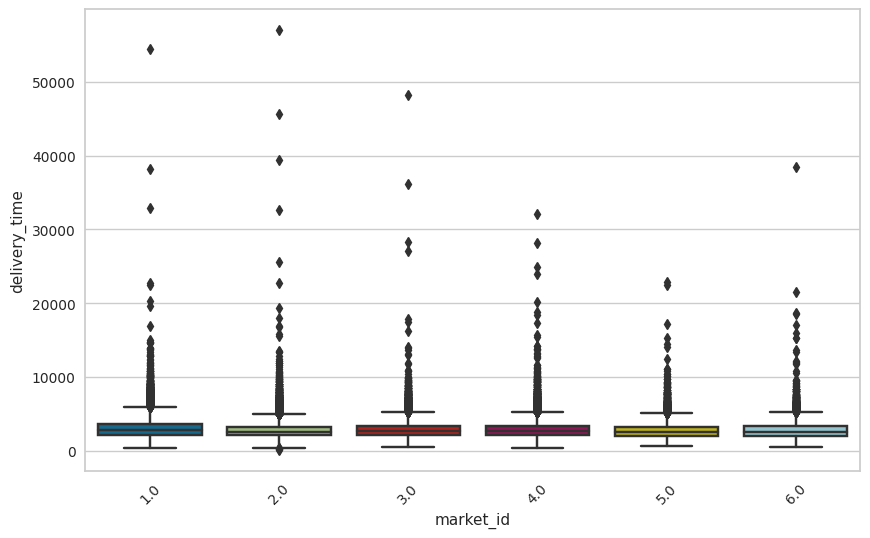

In [53]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='market_id', y='delivery_time', data=cat_nom_df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

Market's 1, 2 and 3 have the longest delivery times.

In [65]:
# There are a bunch of store_id's (6743) to be exact. So need to take sample of the data to plot.

query = """
with top_store_del as (select store_id
, mean(delivery_time) as avg_delivery_time
from cat_nom_df
group by 1
order by 2 desc
limit 10
)

select store_id
, delivery_time
from cat_nom_df
where store_id in (select store_id from top_store_del)
"""

store_dt = duckdb.query(query).df()
store_dt

,store_id,delivery_time
0,2758,4307.0
1,2758,17445.0
2,2758,3292.0
3,1710,2085.0
4,1710,1134.0
5,1710,2906.0
6,1710,2168.0
7,1710,3815.0
8,1710,38457.0
9,2275,11850.0


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '974'),
  Text(1, 0, '1193'),
  Text(2, 0, '1710'),
  Text(3, 0, '2065'),
  Text(4, 0, '2275'),
  Text(5, 0, '2426'),
  Text(6, 0, '2485'),
  Text(7, 0, '2758'),
  Text(8, 0, '3309'),
  Text(9, 0, '6426')])

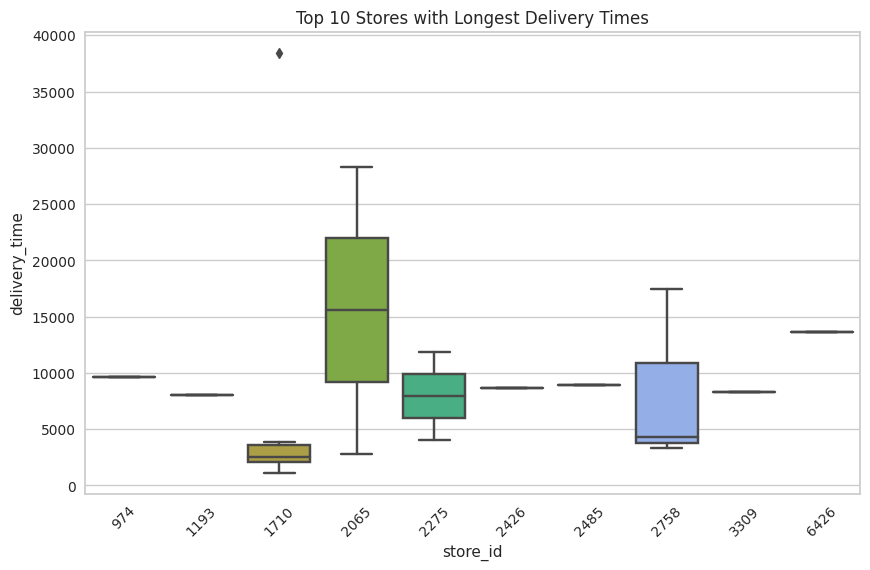

In [70]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='store_id', y='delivery_time', data=store_dt)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.title('Top 10 Stores with Longest Delivery Times')
plt.xticks(rotation=45)

In [74]:
# There are a bunch of store primary categories (6743) to be exact. So need to take sample of the data to plot.

query = """
with top_storecat_del as (select store_primary_category
, mean(delivery_time) as avg_delivery_time
from cat_nom_df
group by 1
order by 2 desc
limit 10
)

select store_primary_category
, delivery_time
from cat_nom_df
where store_primary_category in (select store_primary_category from top_storecat_del)
"""

store_catdt = duckdb.query(query).df()
store_catdt

,store_primary_category,delivery_time
0,japanese,1795.0
1,japanese,3705.0
2,japanese,3262.0
3,japanese,1667.0
4,japanese,2100.0
...,...,...
11296,japanese,4370.0
11297,japanese,3082.0
11298,japanese,3779.0
11299,japanese,5574.0


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'japanese'),
  Text(1, 0, 'cajun'),
  Text(2, 0, 'burmese'),
  Text(3, 0, 'malaysian'),
  Text(4, 0, 'afghan'),
  Text(5, 0, 'spanish'),
  Text(6, 0, 'tapas'),
  Text(7, 0, 'brazilian'),
  Text(8, 0, 'caribbean'),
  Text(9, 0, 'belgian')])

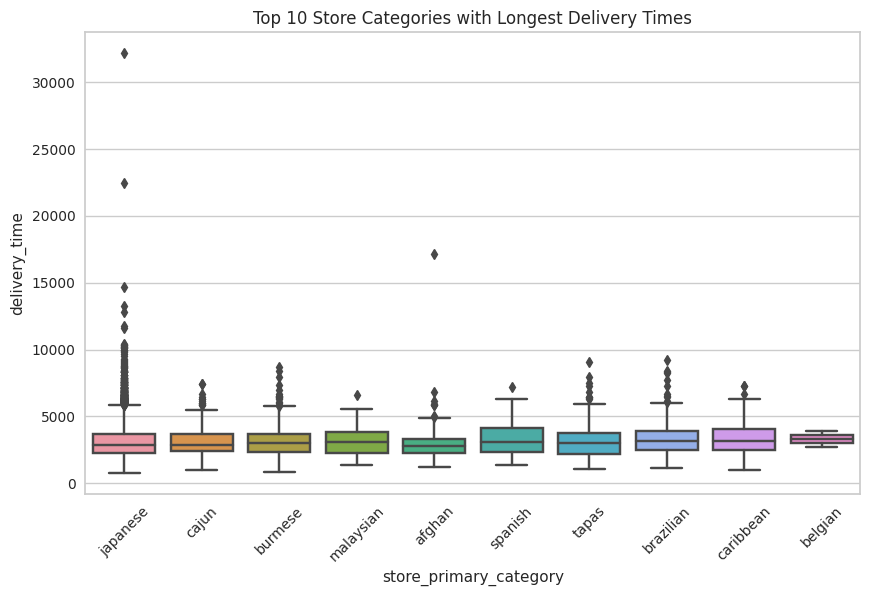

In [77]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='store_primary_category', y='delivery_time', data=store_catdt)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.title('Top 10 Store Categories with Longest Delivery Times')
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, '1.0'),
  Text(1, 0, '2.0'),
  Text(2, 0, '3.0'),
  Text(3, 0, '4.0'),
  Text(4, 0, '5.0'),
  Text(5, 0, '6.0'),
  Text(6, 0, '7.0')])

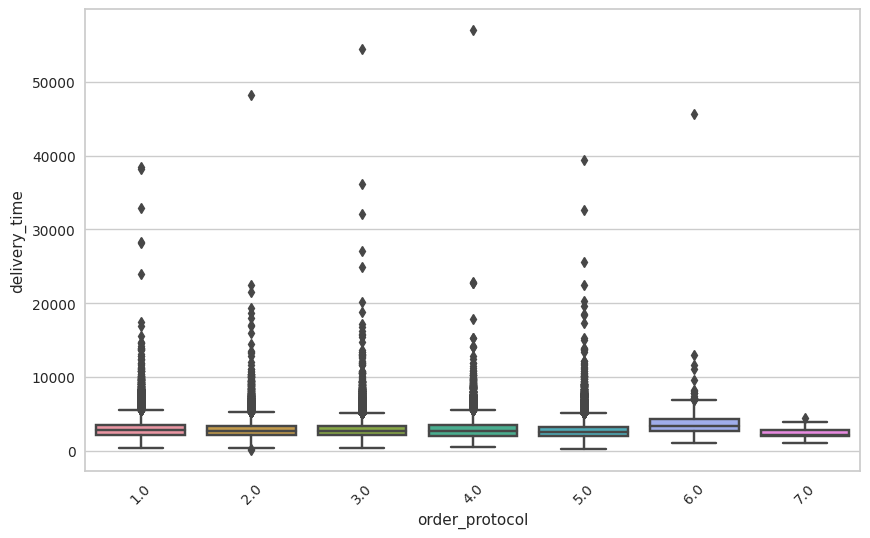

In [78]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='order_protocol', y='delivery_time', data=cat_nom_df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

Order Protocols 3.0 and 4.0 have the longest delivery times.

# Pre-Processing (Imputing, Removing Outliers, Making Categorical numerical) - Use Pycaret for this

In [79]:
# Before pycaret automated outlier removal:
data[['total_items',
 'subtotal',
 'num_distinct_items',
 'min_item_price',
 'max_item_price',
 'total_onshift_dashers',
 'total_busy_dashers',
 'total_outstanding_orders',
 'estimated_order_place_duration',
 'estimated_store_to_consumer_driving_duration',
 'delivery_time']].describe()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_time
count,197416.000000,197416.000000,197416.000000,197416.000000,197416.000000,181155.000000,181155.000000,181155.000000,197416.000000,196890.000000,197416.000000
mean,3.194316,2682.323702,2.670771,686.221360,1159.590388,44.807176,41.739052,58.048290,308.548233,545.357047,2861.567553
std,2.503644,1823.118514,1.630265,522.041266,558.416296,34.526001,32.145248,52.660292,89.977195,219.355906,1164.077104
min,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000,101.000000
25%,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,382.000000,2104.000000
50%,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000,2660.000000
75%,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000,3381.000000
max,84.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,1740.000000,2088.000000,57032.000000


In [80]:
data_test = data[['total_items',
 'subtotal',
 'num_distinct_items',
 'min_item_price',
 'max_item_price',
 'total_onshift_dashers',
 'total_busy_dashers',
 'total_outstanding_orders',
 'estimated_order_place_duration',
 'estimated_store_to_consumer_driving_duration',
 'delivery_time']]

In [81]:
data_test.isnull().sum()

total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16261
total_busy_dashers                              16261
total_outstanding_orders                        16261
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
delivery_time                                       0
dtype: int64

In [82]:
# Impute first to get rid of Null's
# Can't blanket imputation since some variables have outliers that require median vs mean
# So need to perform box/violin plots to see distribution; if guassian like then mean, if skewed then median

# Based on EDA above on each column: need to impute with median since all boxplots show extensive points beyond whiskers (min/max)
data_test.fillna(data_test.median(), inplace=True)

In [83]:
data_test.isnull().sum()

total_items                                     0
subtotal                                        0
num_distinct_items                              0
min_item_price                                  0
max_item_price                                  0
total_onshift_dashers                           0
total_busy_dashers                              0
total_outstanding_orders                        0
estimated_order_place_duration                  0
estimated_store_to_consumer_driving_duration    0
delivery_time                                   0
dtype: int64

In [84]:
data['total_onshift_dashers'].describe(), data_test['total_onshift_dashers'].describe()

(count    181155.000000
 mean         44.807176
 std          34.526001
 min          -4.000000
 25%          17.000000
 50%          37.000000
 75%          65.000000
 max         171.000000
 Name: total_onshift_dashers, dtype: float64,
 count    197416.000000
 mean         44.164105
 std          33.143076
 min          -4.000000
 25%          19.000000
 50%          37.000000
 75%          62.000000
 max         171.000000
 Name: total_onshift_dashers, dtype: float64)

In [85]:
# Compare manual imputation with pycaret imputation
data_test2 = data[['total_items',
 'subtotal',
 'num_distinct_items',
 'min_item_price',
 'max_item_price',
 'total_onshift_dashers',
 'total_busy_dashers',
 'total_outstanding_orders',
 'estimated_order_place_duration',
 'estimated_store_to_consumer_driving_duration',
 'delivery_time']]

In [86]:
len(data), len(data_test), len(data_test2)

In [87]:
# pycaret imputes on dependent variables and not target variable. so manually impute delivery_time before proceeding to pycaret imputation
data_test2['delivery_time'].fillna(data_test['delivery_time'].median(), inplace=True)

In [88]:
from pycaret.regression import *
s_test = setup(data_test2, target = 'delivery_time', numeric_imputation = 'median')

,Description,Value
0,Session id,3519
1,Target,delivery_time
2,Target type,Regression
3,Original data shape,"(197416, 11)"
4,Transformed data shape,"(197416, 11)"
5,Transformed train set shape,"(138191, 11)"
6,Transformed test set shape,"(59225, 11)"
7,Numeric features,10
8,Rows with missing values,8.5%
9,Preprocess,True


In [89]:
# df after setup imputation for numeric indepdent variables
data_test3 = get_config('X_transformed')

In [90]:
data['total_onshift_dashers'].describe(), data_test['total_onshift_dashers'].describe(), data_test3['total_onshift_dashers'].describe()

(count    181155.000000
 mean         44.807176
 std          34.526001
 min          -4.000000
 25%          17.000000
 50%          37.000000
 75%          65.000000
 max         171.000000
 Name: total_onshift_dashers, dtype: float64,
 count    197416.000000
 mean         44.164105
 std          33.143076
 min          -4.000000
 25%          19.000000
 50%          37.000000
 75%          62.000000
 max         171.000000
 Name: total_onshift_dashers, dtype: float64,
 count    197416.000000
 mean         44.164105
 std          33.143076
 min          -4.000000
 25%          19.000000
 50%          37.000000
 75%          62.000000
 max         171.000000
 Name: total_onshift_dashers, dtype: float64)

Observation: pycaret imputation is different than manual imputation since quantiles are different. more similar to non-imputed quantiles.

In [91]:
# Checking some rows between data, data_test and data_test3 to see what was used for imputation

test = data.copy()
test = test.reset_index()

query = """
select *
from test
where total_onshift_dashers IS NULL
"""

duckdb.query(query).df().head()

,index,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,...,hour,day,day_of_week,is_weekend,month,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end
0,159,6.0,2015-02-06 01:11:56,2015-02-06 01:42:51,976,breakfast,2.0,2,575,2,...,1,6,4,0,2,1,0,0,0,0
1,160,6.0,2015-02-14 02:07:47,2015-02-14 03:17:37,976,breakfast,2.0,5,1415,3,...,2,14,5,1,2,1,0,0,0,0
2,161,6.0,2015-01-31 21:58:30,2015-01-31 22:55:32,976,breakfast,2.0,1,650,1,...,21,31,5,1,1,1,0,1,0,0
3,162,6.0,2015-02-08 03:28:59,2015-02-08 05:32:11,976,breakfast,2.0,5,1550,5,...,3,8,6,1,2,1,0,0,0,0
4,163,6.0,2015-01-23 19:29:17,2015-01-23 20:25:25,976,breakfast,2.0,6,1110,5,...,19,23,4,0,1,1,0,0,0,0


In [92]:
test2 = data_test.copy()
test2 = test2.reset_index()

query = """
select *
from test2
where index between 160 and 164
"""

duckdb.query(query).df().head()

,index,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_time
0,160,5,1415,3,185,675,37.0,34.0,41.0,251,893.0,4190.0
1,161,1,650,1,650,650,37.0,34.0,41.0,251,479.0,3422.0
2,162,5,1550,5,225,700,37.0,34.0,41.0,251,1104.0,7392.0
3,163,6,1110,5,185,185,37.0,34.0,41.0,251,584.0,3368.0
4,164,8,2115,8,150,650,37.0,34.0,41.0,251,840.0,2527.0


In [93]:
test3 = data_test3.copy()
test3 = test3.reset_index()

query = """
select *
from test3
where index between 160 and 164
"""

duckdb.query(query).df().head()

,index,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,161,1.0,650.0,1.0,650.0,650.0,37.0,34.0,41.0,251.0,479.0
1,162,5.0,1550.0,5.0,225.0,700.0,37.0,34.0,41.0,251.0,1104.0
2,160,5.0,1415.0,3.0,185.0,675.0,37.0,34.0,41.0,251.0,893.0
3,163,6.0,1110.0,5.0,185.0,185.0,37.0,34.0,41.0,251.0,584.0
4,164,8.0,2115.0,8.0,150.0,650.0,37.0,34.0,41.0,251.0,840.0


Both imputed manually and with pycaret have no NaN's, but have different overall mean's because median for manual: 37 where median used for pycaret: 36. Also, both have tighter std dev bands vs non-imputed. Ok to use pycaret for imputation.

In [94]:
len(test), len(test2), len(test3)

# Other Data Pre-Processing 
* Imputing
* Change negative numbers to 0
* Changing Categorical to Numerical
* Categorize numbers/categories

In [95]:
missing = data.isnull().sum()/len(data) *100
missing[missing > 0]

market_id                                       0.499959
store_primary_category                          2.411152
order_protocol                                  0.504012
total_onshift_dashers                           8.236921
total_busy_dashers                              8.236921
total_outstanding_orders                        8.236921
estimated_store_to_consumer_driving_duration    0.266442
dtype: float64

Missing value processing

* market_id: will drop them
* actual_delivery_time: not sure if the delivery has been cancel, will drop them
* store_primary_category: will ignore
* order_protocol: will ignore
* total_onshift_dashers: system error? may fill up with the avg total_onshift_dashers at same market id and created hour.
* total_busy_dashers: system error?
* total_outstanding_orders: system error?
* estimated_store_to_consumer_driving_duration - get median according to market id and created hour
* delivery_time - get median according to market id and created hour

# Model Evaluation

# Use Picked Model to make Predictions using json file